# Nonlinear MLP Stencil — Optimized Version

This is the optimized version of `nonlinear.ipynb`. The mathematical formulation
is identical; see that notebook for the pedagogical walkthrough.

**Optimizations over `nonlinear.ipynb`:**

| # | Optimization | Complexity | Benefit |
|---|---|---|---|
| 1 | **Tridiagonal (Thomas) solver** instead of dense `linalg.solve` | $O(N)$ vs $O(N^3)$ per Newton step | Dominant at large $N$ |
| 2 | **Reuse accepted Armijo residual** as next Newton `F_val` | Saves 1 MLP forward per Newton iter | ~20–30% fewer evals |
| 3 | **Gradient clipping** via `clip_grad_norm_` | 1 line | Stabilises late-stage training |

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.func import jacrev, vmap, functional_call

## 1. MLP and stencil helpers (unchanged from `nonlinear.ipynb`)

In [2]:
class StencilMLP(nn.Module):
    """MLP: local window -> stencil perturbation.  Final layer zero-init."""
    def __init__(self, stencil_width=3, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(stencil_width, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),        nn.Tanh(),
            nn.Linear(hidden, stencil_width),
        )
        with torch.no_grad():
            self.net[-1].weight.zero_()
            self.net[-1].bias.zero_()

    def forward(self, u_local):
        return self.net(u_local)


def extract_stencil_windows(u, stencil_radius=1):
    N = u.shape[0]
    width = 2 * stencil_radius + 1
    u_padded = torch.cat([u[-stencil_radius:], u, u[:stencil_radius]])
    return u_padded.unfold(0, width, 1)


def apply_nonlinear_stencil(u, mlp_params, mlp_buffers, mlp_forward, base_coeffs):
    windows = extract_stencil_windows(u)
    delta_a = mlp_forward(mlp_params, mlp_buffers, windows)
    a_eff = base_coeffs.unsqueeze(0) + delta_a
    return (a_eff * windows).sum(dim=1)


def implicit_euler_residual(u_new, u_old, dt, mlp_params, mlp_buffers,
                            mlp_forward, base_coeffs):
    Lu = apply_nonlinear_stencil(u_new, mlp_params, mlp_buffers,
                                 mlp_forward, base_coeffs)
    return u_new - u_old - dt * Lu

## 2. O(N) tridiagonal (Thomas) solver

The Jacobian of the implicit Euler residual is a periodic tridiagonal matrix
(tridiagonal + two corner entries from the periodic BCs).  We handle this
with the **Sherman–Morrison** formula: write

$$A_{\text{periodic}} = A_{\text{tridiag}} + \mathbf{u}\mathbf{v}^T$$

where the rank-1 correction accounts for the two corner entries.  Then

$$A_{\text{periodic}}^{-1} b = A_{\text{tridiag}}^{-1} b
  - \frac{A_{\text{tridiag}}^{-1} u \; (v^T A_{\text{tridiag}}^{-1} b)}
         {1 + v^T A_{\text{tridiag}}^{-1} u}$$

The Thomas algorithm solves $A_{\text{tridiag}} x = b$ in $O(N)$.
The whole procedure is $O(N)$ and **differentiable** (pure PyTorch ops).

In [10]:
def thomas_solve(lower, main, upper, rhs):
    """Solve a (non-periodic) tridiagonal system Ax = rhs in O(N).
    
    All operations are out-of-place so the function is autograd-safe.
    
    Parameters
    ----------
    lower : (N,) — sub-diagonal (lower[0] unused, lower[i] = A[i, i-1])
    main  : (N,) — main diagonal
    upper : (N,) — super-diagonal (upper[N-1] unused, upper[i] = A[i, i+1])
    rhs   : (N,) — right-hand side
    
    Returns x : (N,)
    """
    N = main.shape[0]

    # Build lists of scalars — no in-place mutation
    m_list = [main[0]]
    d_list = [rhs[0]]

    for i in range(1, N):
        w = lower[i] / m_list[i - 1]
        m_list.append(main[i] - w * upper[i - 1])
        d_list.append(rhs[i] - w * d_list[i - 1])

    # Back substitution into a list
    x_list = [None] * N
    x_list[N - 1] = d_list[N - 1] / m_list[N - 1]
    for i in range(N - 2, -1, -1):
        x_list[i] = (d_list[i] - upper[i] * x_list[i + 1]) / m_list[i]

    return torch.stack(x_list)


def periodic_tridiag_solve(lower_diag, main_diag, upper_diag,
                           corner_top_right, corner_bot_left, rhs):
    """Solve a periodic tridiagonal system in O(N) via Sherman-Morrison.
    
    The system is tridiagonal with two extra entries:
        A[0, N-1] = corner_top_right
        A[N-1, 0] = corner_bot_left
    """
    N = main_diag.shape[0]
    gamma = -main_diag[0]

    # Modified main diagonal (out-of-place via cat)
    m_mod = torch.cat([
        (main_diag[0] - gamma).unsqueeze(0),
        main_diag[1:N-1],
        (main_diag[N-1] - corner_top_right * corner_bot_left / gamma).unsqueeze(0),
    ])

    # u vector for rank-1 correction
    u_vec = torch.zeros(N, dtype=rhs.dtype, device=rhs.device)
    u_vec = u_vec + 0  # ensure fresh tensor
    u_mid = torch.zeros(N, dtype=rhs.dtype, device=rhs.device)
    u_vec = torch.cat([
        gamma.unsqueeze(0) if gamma.dim() == 0 else gamma.unsqueeze(0),
        torch.zeros(N - 2, dtype=rhs.dtype, device=rhs.device),
        corner_top_right.unsqueeze(0),
    ])

    v_vec = torch.cat([
        torch.ones(1, dtype=rhs.dtype, device=rhs.device),
        torch.zeros(N - 2, dtype=rhs.dtype, device=rhs.device),
        (corner_bot_left / gamma).unsqueeze(0),
    ])

    # Solve two tridiagonal systems
    y = thomas_solve(lower_diag, m_mod, upper_diag, rhs)
    q = thomas_solve(lower_diag, m_mod, upper_diag, u_vec)

    # Sherman-Morrison formula
    vTy = v_vec.dot(y)
    vTq = v_vec.dot(q)
    x = y - (vTy / (1.0 + vTq)) * q

    return x

## 3. Jacobian assembly (returns diagonals, not dense matrix)

In [11]:
def assemble_jacobian_diags(u_new, u_old, dt, mlp_params, mlp_buffers,
                            mlp_forward, base_coeffs):
    """Assemble the Jacobian as 3 diagonal vectors (N,) via vmap+jacrev.
    
    Returns (lower, main, upper, corner_top_right, corner_bot_left).
    """
    N = u_new.shape[0]
    windows = extract_stencil_windows(u_new)

    def local_res_fn(u_local_3, u_old_i):
        delta_a = mlp_forward(mlp_params, mlp_buffers,
                              u_local_3.unsqueeze(0)).squeeze(0)
        a_eff = base_coeffs + delta_a
        Lu_i = (a_eff * u_local_3).sum()
        return u_local_3[1] - u_old_i - dt * Lu_i

    local_jac_fn = jacrev(local_res_fn, argnums=0)
    all_local_jacs = vmap(local_jac_fn)(windows, u_old)  # (N, 3)

    # all_local_jacs[:, 0] = dF_i/du_{i-1}  (sub-diagonal)
    # all_local_jacs[:, 1] = dF_i/du_i       (main diagonal)
    # all_local_jacs[:, 2] = dF_i/du_{i+1}   (super-diagonal)
    lower = all_local_jacs[:, 0]  # lower[i] = J[i, i-1]; lower[0] is corner
    main  = all_local_jacs[:, 1]
    upper = all_local_jacs[:, 2]  # upper[i] = J[i, i+1]; upper[N-1] is corner

    # Extract periodic corner entries and zero them from the tri-diag vectors
    corner_top_right = lower[0].clone()   # J[0, N-1]
    corner_bot_left  = upper[N-1].clone() # J[N-1, 0]

    # Zero out corners in the tridiagonal vectors (they belong to corners only)
    lower = lower.clone()
    upper = upper.clone()
    lower[0] = 0.0
    upper[N-1] = 0.0

    return lower, main, upper, corner_top_right, corner_bot_left

## 4. Newton solver (optimized)

Changes vs `nonlinear.ipynb`:
- Uses `periodic_tridiag_solve` ($O(N)$) instead of `linalg.solve` ($O(N^3)$)
- Reuses the accepted Armijo residual `F_trial` as the next iteration's `F_val`

In [12]:
def newton_solve(u_init, u_old, dt, mlp_params, mlp_buffers, mlp_forward,
                 base_coeffs, tol=1e-10, max_iter=20, verbose=False):
    """Solve F(u) = u - u_old - dt*L[u] = 0 via Newton + Armijo.
    
    Optimized: O(N) tridiagonal solve, residual reuse, implicit-function
    differentiable correction at the end.
    """
    u = u_init.detach().clone()
    F_cached = None  # will hold reusable residual from Armijo

    for k in range(max_iter):
        # --- Residual evaluation (reuse from last Armijo if available) ---
        with torch.no_grad():
            if F_cached is not None:
                F_val = F_cached
                F_cached = None
            else:
                F_val = implicit_euler_residual(u, u_old, dt, mlp_params,
                                               mlp_buffers, mlp_forward, base_coeffs)
            res_norm = F_val.norm().item()
            if verbose:
                print(f"  Newton iter {k}: ||F|| = {res_norm:.3e}")
            if res_norm < tol:
                break

        # --- Jacobian (needs enable_grad for jacrev) ---
        with torch.enable_grad():
            lo, ma, up, ctr, cbl = assemble_jacobian_diags(
                u, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)

        with torch.no_grad():
            # O(N) tridiagonal solve
            delta_u = periodic_tridiag_solve(
                lo.detach(), ma.detach(), up.detach(),
                ctr.detach(), cbl.detach(), -F_val)

            # Armijo backtracking (reuse accepted F_trial)
            alpha = 1.0
            c1 = 1e-4
            tau = 0.5
            phi_current = 0.5 * F_val.dot(F_val)
            directional_deriv = -F_val.dot(F_val)

            F_trial = None
            for _ in range(20):
                u_trial = u + alpha * delta_u
                F_trial = implicit_euler_residual(
                    u_trial, u_old, dt, mlp_params, mlp_buffers,
                    mlp_forward, base_coeffs)
                phi_trial = 0.5 * F_trial.dot(F_trial)
                if phi_trial <= phi_current + c1 * alpha * directional_deriv:
                    break
                alpha *= tau

            u = u + alpha * delta_u
            F_cached = F_trial  # reuse in next iteration

    # --- Differentiable correction (implicit function theorem) ---
    u_det = u.detach()
    F_val = implicit_euler_residual(u_det, u_old, dt, mlp_params, mlp_buffers,
                                    mlp_forward, base_coeffs)
    lo, ma, up, ctr, cbl = assemble_jacobian_diags(
        u_det, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)
    delta_u = periodic_tridiag_solve(lo, ma, up, ctr, cbl, -F_val)
    return u_det + delta_u

## 5. Training setup

In [13]:
N = 50
M = 5
device = 'cpu'

dx = 1.0 / N
dt = 0.01
x_grid = torch.linspace(0, 1.0 - dx, N, device=device)
t_grid = torch.linspace(0, dt * M, M + 1, device=device)

u_true_snapshots = torch.stack([
    torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    for t in t_grid
])

base_coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)

print(f"Grid: N={N}, dx={dx:.4f}")
print(f"Time: M={M} steps, dt={dt}")
print(f"Base stencil: {base_coeffs.tolist()}")

Grid: N=50, dx=0.0200
Time: M=5 steps, dt=0.01
Base stencil: [2500.0, -5000.0, 2500.0]


In [14]:
mlp = StencilMLP(stencil_width=3, hidden=16).to(device)

mlp_params = dict(mlp.named_parameters())
mlp_buffers = dict(mlp.named_buffers())

def mlp_forward(params, buffers, x):
    return functional_call(mlp, (params, buffers), (x,))

test_window = torch.randn(1, 3)
print("MLP output at init (should be ~0):", mlp_forward(mlp_params, mlp_buffers, test_window))

MLP output at init (should be ~0): tensor([[0., 0., 0.]], grad_fn=<AddmmBackward0>)


## 6. Verify Newton solver at initialisation

In [15]:
u0 = u_true_snapshots[0].clone()
u1_newton = newton_solve(u0, u0, dt, mlp_params, mlp_buffers, mlp_forward,
                         base_coeffs, tol=1e-10, max_iter=10, verbose=True)

# Reference: dense linear solve
D_lin = torch.zeros(N, N)
for i in range(N):
    D_lin[i, (i-1) % N] = base_coeffs[0]
    D_lin[i, i]          = base_coeffs[1]
    D_lin[i, (i+1) % N] = base_coeffs[2]
A_lin = torch.eye(N) - dt * D_lin
u1_linear = torch.linalg.solve(A_lin, u0)

print(f"\n||Newton - LinearSolve|| = {(u1_newton - u1_linear).norm():.3e}  (should be ~0)")

  Newton iter 0: ||F|| = 1.971e+00
  Newton iter 1: ||F|| = 1.230e-05
  Newton iter 2: ||F|| = 9.477e-06
  Newton iter 3: ||F|| = 9.291e-06
  Newton iter 4: ||F|| = 8.371e-06
  Newton iter 5: ||F|| = 7.764e-06
  Newton iter 6: ||F|| = 7.731e-06
  Newton iter 7: ||F|| = 7.731e-06
  Newton iter 8: ||F|| = 7.731e-06
  Newton iter 9: ||F|| = 7.731e-06

||Newton - LinearSolve|| = 1.456e-06  (should be ~0)


## 7. Training loop (with gradient clipping)

In [16]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
num_epochs = 500
grad_clip_norm = 1.0  # <-- Optimization 3: gradient clipping

print(f"{'Epoch':<8} {'Loss':<15} {'GradNorm':<12}")
print("-" * 40)

loss_history = []
cached_solutions = [u_true_snapshots[0].clone().detach() for _ in range(M + 1)]

for epoch in range(num_epochs):
    optimizer.zero_grad()

    mlp_params = dict(mlp.named_parameters())
    mlp_buffers = dict(mlp.named_buffers())

    total_loss = torch.tensor(0.0, device=device)
    u_current = u_true_snapshots[0].clone()

    for step in range(M):
        u_guess = cached_solutions[step + 1]
        u_next = newton_solve(u_guess, u_current, dt,
                              mlp_params, mlp_buffers, mlp_forward,
                              base_coeffs, tol=1e-5, max_iter=10)
        cached_solutions[step + 1] = u_next.detach().clone()

        step_loss = torch.mean((u_next - u_true_snapshots[step + 1]) ** 2)
        total_loss = total_loss + step_loss
        u_current = u_next

    loss = total_loss / M
    loss.backward()

    # Optimization 3: clip gradients for stability
    gn = torch.nn.utils.clip_grad_norm_(mlp.parameters(), grad_clip_norm).item()

    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 25 == 0 or epoch == num_epochs - 1:
        print(f"{epoch:<8} {loss.item():<15.3e} {gn:<12.3e}")

print("\nTraining complete.")

Epoch    Loss            GradNorm    
----------------------------------------
0        1.550e-03       9.205e-04   
25       1.372e-03       1.084e-03   
50       1.044e-03       1.243e-03   
75       6.497e-04       1.190e-03   
100      3.404e-04       9.424e-04   
125      1.618e-04       6.691e-04   
150      7.309e-05       4.520e-04   
175      3.173e-05       2.971e-04   
200      1.321e-05       1.910e-04   
225      5.239e-06       1.198e-04   
250      1.970e-06       7.328e-05   
275      6.994e-07       4.355e-05   
300      2.337e-07       2.508e-05   
325      7.366e-08       1.397e-05   
350      2.240e-08       7.503e-06   
375      7.185e-09       3.890e-06   
400      2.974e-09       1.942e-06   
425      1.888e-09       9.225e-07   
450      1.630e-09       4.101e-07   
475      1.583e-09       1.836e-07   
499      1.568e-09       8.518e-08   

Training complete.


## 8. Visualisation

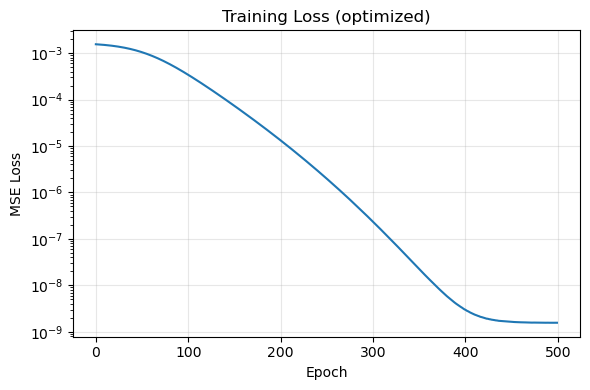

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy(loss_history)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss (optimized)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

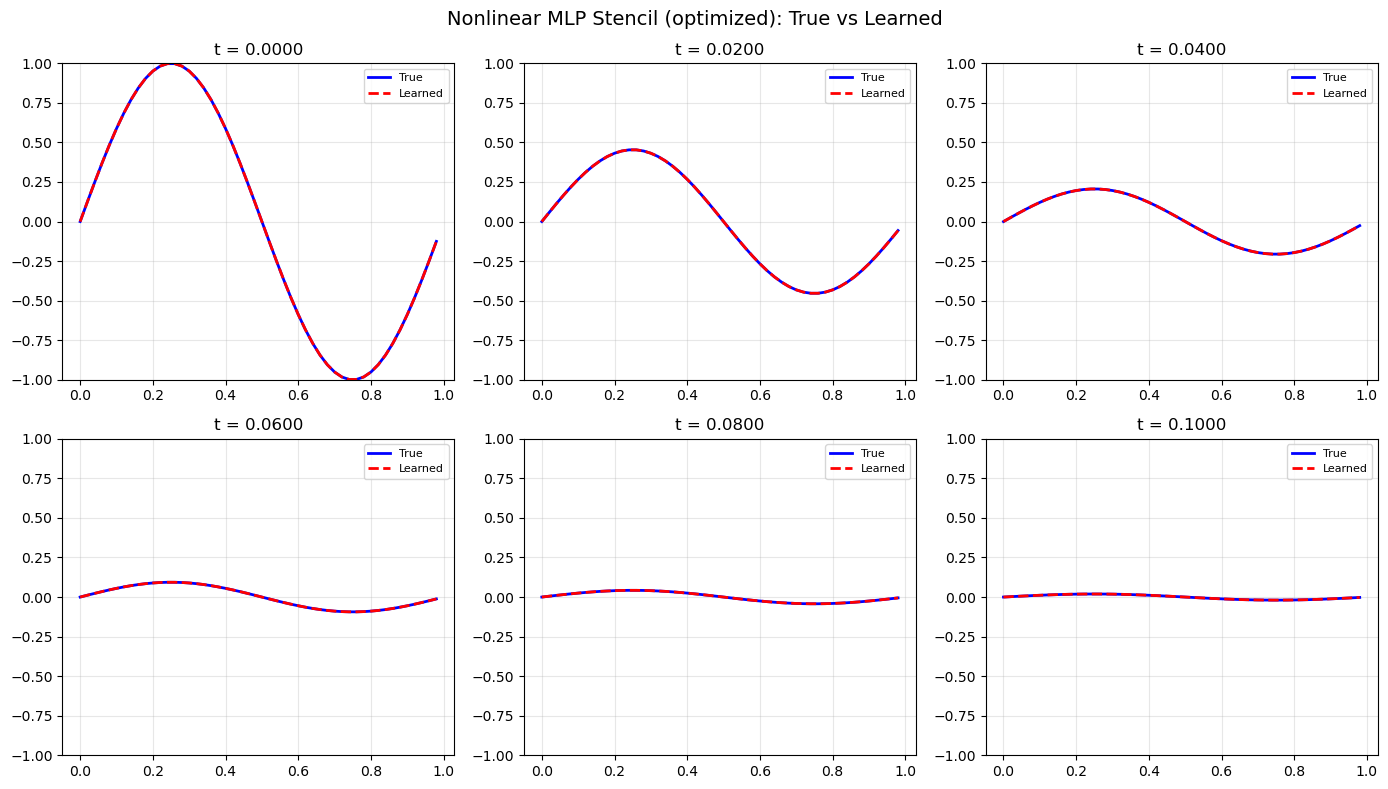

In [18]:
mlp.eval()
mlp_params_eval = dict(mlp.named_parameters())
mlp_buffers_eval = dict(mlp.named_buffers())

M_test = 10
t_test = torch.linspace(0, dt * M_test, M_test + 1, device=device)
u_true_test = torch.stack([
    torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    for t in t_test
])

u_learned = torch.zeros(M_test + 1, N, device=device)
u_learned[0] = u_true_test[0].clone()

with torch.no_grad():
    for step in range(M_test):
        u_learned[step + 1] = newton_solve(
            u_learned[step], u_learned[step], dt,
            mlp_params_eval, mlp_buffers_eval, mlp_forward,
            base_coeffs, tol=1e-10, max_iter=20)

x_np = x_grid.numpy()
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Nonlinear MLP Stencil (optimized): True vs Learned', fontsize=14)
snap_idx = [0, 2, 4, 6, 8, M_test]
for idx, si in enumerate(snap_idx):
    ax = axes[idx // 3, idx % 3]
    ax.plot(x_np, u_true_test[si].numpy(), 'b-', lw=2, label='True')
    ax.plot(x_np, u_learned[si].numpy(), 'r--', lw=2, label='Learned')
    ax.set_title(f't = {t_test[si]:.4f}')
    ax.set_ylim([-1, 1])
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Inspect the learned stencil

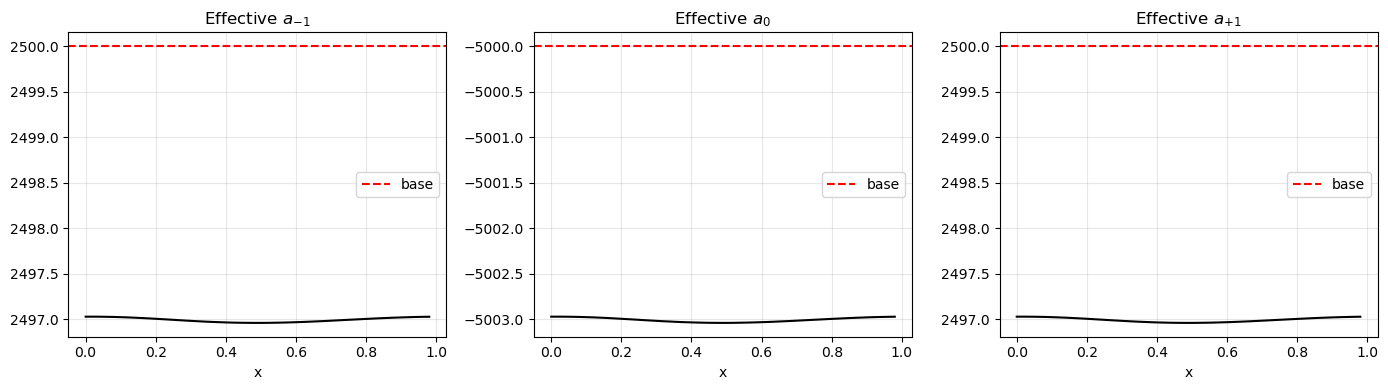

In [19]:
with torch.no_grad():
    windows_ic = extract_stencil_windows(u_true_test[0])
    delta_a_ic = mlp_forward(mlp_params_eval, mlp_buffers_eval, windows_ic)
    a_eff_ic = base_coeffs.unsqueeze(0) + delta_a_ic

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
labels = ['$a_{-1}$', '$a_0$', '$a_{+1}$']
for k in range(3):
    axes[k].plot(x_np, a_eff_ic[:, k].numpy(), 'k-', lw=1.5)
    axes[k].axhline(base_coeffs[k].item(), color='r', ls='--', label='base')
    axes[k].set_title(f'Effective {labels[k]}')
    axes[k].set_xlabel('x')
    axes[k].legend()
    axes[k].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()